<a href="https://colab.research.google.com/github/alfiannnas/tbc-detection-app/blob/main/UnderSamplingTBC_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TBC Detection using CNN

## Import Library

In [1]:
import shutil
import kagglehub
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img


## Import Dataset

In [2]:
# Download datesetlatest version
path = kagglehub.dataset_download("tawsifurrahman/tuberculosis-tb-chest-xray-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/tuberculosis-tb-chest-xray-dataset


In [3]:
# Use the actual path returned by kagglehub
dst_path = "/content/dataset"

shutil.copytree(path, dst_path, dirs_exist_ok=True)

print("Dataset copied to:", dst_path)


Dataset copied to: /content/dataset


## Load Dataset

### Check Dataset

In [4]:
# Check and Count our Dataset
path = '/content/dataset/TB_Chest_Radiography_Database'
counter = 0
dir_names=['Normal', 'Tuberculosis']

for file in (dir_names):
    dir = os.listdir(f"{path}/{file}")

    print(f"Data for {file} is {len(dir)}")

Data for Normal is 3500
Data for Tuberculosis is 700


### Load Metadata

In [5]:
# Load Metadata
df_norm = pd.read_excel('/content/dataset/TB_Chest_Radiography_Database/Normal.metadata.xlsx')
df_tb = pd.read_excel('/content/dataset/TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx')

In [6]:
# Undersampling Normal Class and Check Sample Data of Normal Metadata
df_norm = df_norm.sample(n=700, random_state=42)

df_norm


,FILE NAME,FORMAT,SIZE,URL
1650,Normal-1651,PNG,512*512,https://www.kaggle.com/c/rsna-pneumonia-detect...
2456,Normal-2457,PNG,512*512,https://www.kaggle.com/c/rsna-pneumonia-detect...
2232,Normal-2233,PNG,512*512,https://www.kaggle.com/c/rsna-pneumonia-detect...
1945,Normal-1946,PNG,512*512,https://www.kaggle.com/c/rsna-pneumonia-detect...
309,Normal-310,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
...,...,...,...,...
3127,Normal-3128,PNG,512*512,https://www.kaggle.com/c/rsna-pneumonia-detect...
744,Normal-745,PNG,512*512,https://www.kaggle.com/c/rsna-pneumonia-detect...
631,Normal-632,PNG,512*512,https://www.kaggle.com/c/rsna-pneumonia-detect...
1557,Normal-1558,PNG,512*512,https://www.kaggle.com/c/rsna-pneumonia-detect...


In [7]:
# Check Sample Data of Tuberculosis Metadata
df_tb

,FILE NAME,FORMAT,SIZE,URL
0,Tuberculosis-1,PNG,512*512,http://tuberculosis.by/
1,Tuberculosis-2,PNG,512*512,http://tuberculosis.by/
2,Tuberculosis-3,PNG,512*512,http://tuberculosis.by/
3,Tuberculosis-4,PNG,512*512,http://tuberculosis.by/
4,Tuberculosis-5,PNG,512*512,http://tuberculosis.by/
...,...,...,...,...
695,Tuberculosis-696,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
696,Tuberculosis-697,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
697,Tuberculosis-698,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
698,Tuberculosis-699,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...


In [8]:
# Add Label for Every row of metadata ['Tuberculosis']
df_norm['Tuberculosis'] = float(0)
df_tb['Tuberculosis'] = float(1)

# Remove Unused Column
df_norm.drop(columns = ['FORMAT', 'SIZE', 'URL'], inplace = True)
df_tb.drop(columns = ['FORMAT', 'SIZE', 'URL'], inplace = True)


In [9]:
# Merge DF Normal and DF Tuberculosis into 1 Dataframe
df = pd.concat([df_norm, df_tb])
df = df.sample(frac=1).reset_index(drop=True)

# Set Label
label = ['Tuberculosis']

In [10]:
# Check Our Result of Dataframe After Merged
df

,FILE NAME,Tuberculosis
0,Tuberculosis-673,1.0
1,Normal-479,0.0
2,Normal-799,0.0
3,Normal-818,0.0
4,Normal-255,0.0
...,...,...
1395,Tuberculosis-552,1.0
1396,Normal-45,0.0
1397,Tuberculosis-196,1.0
1398,Tuberculosis-200,1.0


## Split Data

In [11]:
# Create Folder Training, Validation, and Testing
root_path = './'
train_dir = os.path.join(root_path, 'training')
val_dir = os.path.join(root_path, 'validation')
test_dir = os.path.join(root_path, 'testing')

# Create All Necessary Directories
for split in ['training', 'validation', 'testing']:
    for label in ['Normal', 'Tuberculosis']:
        os.makedirs(os.path.join(root_path, split, label), exist_ok=True)

os.makedirs(os.path.join(root_path, 'Images'), exist_ok=True)

In [12]:
# Set Path Directory of Data Folder That Has Been Created Before

IMAGE_DIR = os.path.join('./', 'Images')

TRAINING_DIR = "./training"
VAL_DIR = "./validation"
TESTING_DIR = "./testing"

TRAINING_NORM_DIR = os.path.join(TRAINING_DIR, "Normal/")
VAL_NORM_DIR = os.path.join(VAL_DIR, "Normal/")
TESTING_NORM_DIR = os.path.join(TESTING_DIR, "Normal/")

TRAINING_TB_DIR = os.path.join(TRAINING_DIR, "Tuberculosis/")
VAL_TB_DIR = os.path.join(VAL_DIR, "Tuberculosis/")
TESTING_TB_DIR = os.path.join(TESTING_DIR, "Tuberculosis/")

In [13]:
# Set Path Directory Source of Dataset

PATH_NORM = os.path.join(path, 'Normal')
PATH_TB = os.path.join(path, 'Tuberculosis')

In [14]:
# Function to Split Data. So the Data from the source its copied into Training, Validation, and Testing Folder

def split_data(SOURCE, TRAINING, VAL, TESTING, SPLIT_SIZE_TRAIN = 0.8, SPLIT_SIZE_VAL = 0.1):

  zero_dir = [fn for fn in os.listdir(SOURCE) if os.path.getsize(os.path.join(SOURCE, fn)) == 0]
  for fn in zero_dir :
    print(fn,'Skipping, Ignore Zero Length!')

  use_dir = [fn for fn in os.listdir(SOURCE) if fn not in zero_dir]
  random.seed(2)
  train_dt = random.sample(use_dir, np.int64(SPLIT_SIZE_TRAIN * len(use_dir)))
  test_dt = [fn for fn in use_dir if fn not in train_dt]
  val_dt = random.sample(test_dt, np.int64(SPLIT_SIZE_VAL * len(use_dir)))
  test_dt = [fn for fn in test_dt if fn not in val_dt]
  for fn in train_dt :
    shutil.copy(os.path.join(SOURCE, fn), TRAINING)
  for fn in val_dt :
    shutil.copy(os.path.join(SOURCE, fn), VAL)
  for fn in test_dt:
    shutil.copy(os.path.join(SOURCE, fn), TESTING)


split_data(PATH_NORM, TRAINING_NORM_DIR, VAL_NORM_DIR,  TESTING_NORM_DIR)
split_data(PATH_TB, TRAINING_TB_DIR, VAL_TB_DIR,  TESTING_TB_DIR)

In [15]:
# Function to count files in a directory

def count_files(path):
    return len(os.listdir(path))

# --- Normal ---
print("Normal Data Split:")
print(f"Training: {count_files(TRAINING_NORM_DIR)} images")
print(f"Validation: {count_files(VAL_NORM_DIR)} images")
print(f"Testing: {count_files(TESTING_NORM_DIR)} images\n")

# --- Tuberculosis ---
print("Tuberculosis Data Split:")
print(f"Training: {count_files(TRAINING_TB_DIR)} images")
print(f"Validation: {count_files(VAL_TB_DIR)} images")
print(f"Testing: {count_files(TESTING_TB_DIR)} images")


Normal Data Split:
Training: 2800 images
Validation: 350 images
Testing: 350 images

Tuberculosis Data Split:
Training: 560 images
Validation: 70 images
Testing: 70 images


In [16]:
# Function to copy image from 2 sources (PATH_NORM and PATH_TB) into 1 folder.
# Then, skip file when the size is 0 bytes

def images_copy(SOURCE_N, SOURCE_TB, IMAGE_DIR ):

    zero_dir = [fn for fn in os.listdir(SOURCE_N) if os.path.getsize(os.path.join(SOURCE_N, fn)) == 0]
    zero_dir.append([fn for fn in os.listdir(SOURCE_TB) if os.path.getsize(os.path.join(SOURCE_TB, fn)) == 0])

    for fn in zero_dir :
        print(fn,'is zero length, so ignoring.')

    use_dir_n = [fn for fn in os.listdir(SOURCE_N) if fn not in zero_dir]
    use_dir_tb = [fn for fn in os.listdir(SOURCE_TB) if fn not in zero_dir]
    random.seed(2)

    for fn in use_dir_n :
        shutil.copy(os.path.join(SOURCE_N, fn), IMAGE_DIR)
    for fn in use_dir_tb :
        shutil.copy(os.path.join(SOURCE_TB, fn), IMAGE_DIR)

images_copy(PATH_NORM, PATH_TB, IMAGE_DIR )

[] is zero length, so ignoring.


In [17]:
# Count file in IMAGE_DIR after being copied before

len(os.listdir(IMAGE_DIR))

4200

In [18]:
# Function to create df_train, df_val, df_test

def create_df(NORM_DIR, TB_DIR , df ):
    df_fn_n = os.listdir(NORM_DIR)
    df_fn_tb = os.listdir(TB_DIR)
    df_fn = df_fn_n + df_fn_tb
    df_ext = []
    for fn in df_fn:
        df_ext.append(fn[:-4])
    df_res = df[df['FILE NAME'].isin(df_ext)]

    return df_res

In [19]:
# Create dataframe

train_df = create_df(TRAINING_NORM_DIR, TRAINING_TB_DIR, df)
val_df = create_df(VAL_NORM_DIR, VAL_TB_DIR, df)
test_df = create_df(TESTING_NORM_DIR, TESTING_TB_DIR, df)

In [20]:
print(train_df)
print(val_df)
print(test_df)


             FILE NAME  Tuberculosis
1           Normal-479           0.0
2           Normal-799           0.0
3           Normal-818           0.0
5      Tuberculosis-45           1.0
7     Tuberculosis-386           1.0
...                ...           ...
1394        Normal-943           0.0
1396         Normal-45           0.0
1397  Tuberculosis-196           1.0
1398  Tuberculosis-200           1.0
1399       Normal-1984           0.0

[1127 rows x 2 columns]
             FILE NAME  Tuberculosis
4           Normal-255           0.0
14    Tuberculosis-385           1.0
25    Tuberculosis-280           1.0
57    Tuberculosis-502           1.0
66         Normal-1386           0.0
...                ...           ...
1366  Tuberculosis-151           1.0
1370  Tuberculosis-302           1.0
1381        Normal-706           0.0
1389  Tuberculosis-484           1.0
1395  Tuberculosis-552           1.0

[136 rows x 2 columns]
             FILE NAME  Tuberculosis
0     Tuberculosis-673    

In [21]:
# Add .png as suffix in FILE NAME column. Because our images name has .png as suffix also

train_df['FILE NAME'] = train_df['FILE NAME'] + '.png'
val_df['FILE NAME'] = val_df['FILE NAME'] + '.png'
test_df['FILE NAME'] = test_df['FILE NAME'] + '.png'

<ipython-input-21-e30a31cffbd6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['FILE NAME'] = train_df['FILE NAME'] + '.png'
<ipython-input-21-e30a31cffbd6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['FILE NAME'] = val_df['FILE NAME'] + '.png'
<ipython-input-21-e30a31cffbd6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [22]:
# Check all dataframe rows
print(train_df.shape[0] + val_df.shape[0] + test_df.shape[0])

1400


In [23]:
import glob
train_norm = glob.glob(TRAINING_NORM_DIR +'/*.png')
train_tb = glob.glob(TRAINING_TB_DIR + '/*.png')

Normal


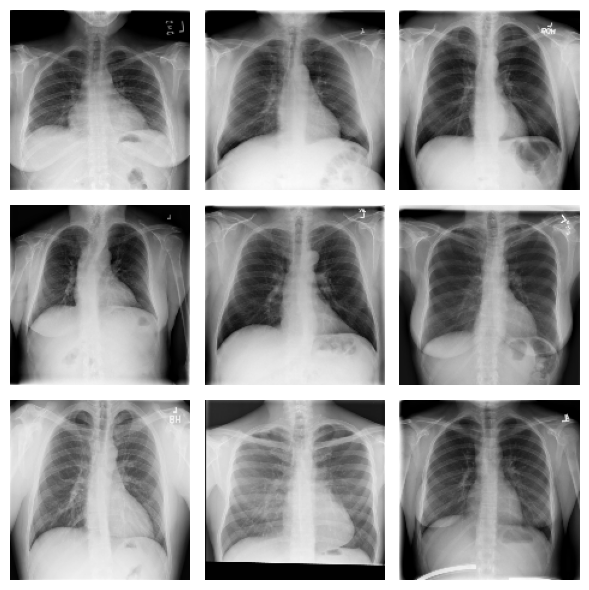

In [24]:
print('Normal')

plt.figure(figsize=(6,6))

for i in range(0, 9):
    plt.subplot(3,3,i + 1)
    img = cv2.imread(train_norm[i])
    img = cv2.resize(img, (150,150))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

Tuberculosis


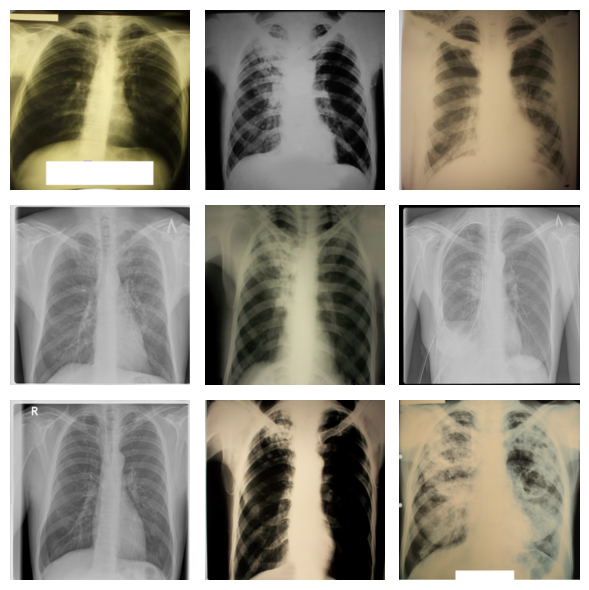

In [25]:
print('Tuberculosis')

plt.figure(figsize=(6,6))

for i in range(0, 9):
    plt.subplot(3,3,i + 1)
    img = cv2.imread(train_tb[i])
    img = cv2.resize(img, (320,320))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

## Data Preprocessing

In [26]:
# Params Configuration
x_col = 'FILE NAME'
y_col = 'Tuberculosis'
target_w = 320
target_h = 320
batch_size = 8
shuffle = True
seed = 1

# Data Augmentation
image_generator = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    zoom_range=0.1,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Create Train Generator
train_generator = image_generator.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGE_DIR,
    x_col=x_col,
    y_col=y_col,
    class_mode="raw",
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed,
    target_size=(target_w, target_h)
)

# Sample Data of Train Generator
images, labels = next(train_generator)
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)


Found 1127 validated image filenames.
Images shape: (8, 320, 320, 3)
Labels shape: (8,)


In [27]:
# Params Configuration
sample_size = 100
batch_size = 8
seed = 1
target_w = 320
target_h = 320

# Getting Sample
raw_train_generator = ImageDataGenerator().flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGE_DIR,
    x_col=x_col,
    y_col=y_col,
    class_mode="raw",
    batch_size=sample_size,
    shuffle=True,
    seed=seed,
    target_size=(target_w, target_h)
)

# Get 1 batch sample from training generator
batch = next(raw_train_generator)
data_sample = batch[0]  # hanya ambil data gambarnya

# Get mean and std
image_generator = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True
)

# Fit mean and std from sample training data
image_generator.fit(data_sample)

# Create validation generator
val_generator = image_generator.flow_from_dataframe(
    dataframe=val_df,
    directory=IMAGE_DIR,
    x_col=x_col,
    y_col=y_col,
    class_mode="raw",
    batch_size=batch_size,
    shuffle=False,
    seed=seed,
    target_size=(target_w, target_h)
)

# Create test generator
test_generator = image_generator.flow_from_dataframe(
    dataframe=test_df,
    directory=IMAGE_DIR,
    x_col=x_col,
    y_col=y_col,
    class_mode="raw",
    batch_size=batch_size,
    shuffle=False,
    seed=seed,
    target_size=(target_w, target_h)
)


Found 1127 validated image filenames.
Found 136 validated image filenames.
Found 137 validated image filenames.


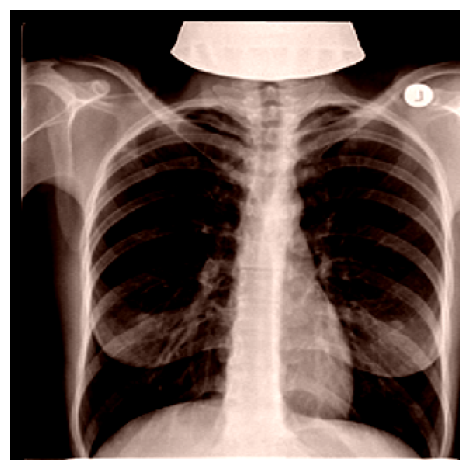

Image shape (320, 320, 3)


In [43]:
x, y = test_generator.__getitem__(0)
plt.imshow(x[0])
plt.axis("off")
plt.tight_layout()
plt.show()
print('Image shape',x[0].shape)

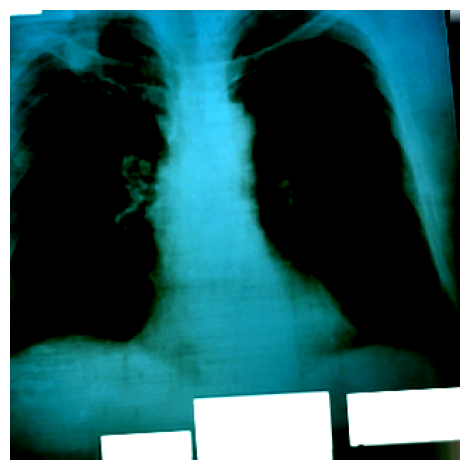

Image shape (320, 320, 3)


In [44]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0])
plt.axis("off")
plt.tight_layout()
plt.show()
print('Image shape',x[0].shape)

In [45]:

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D , Dense
from keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity

## Create Architecture of Model

In [30]:
# Create pre-trained model (Transfer Learning) => DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, classes=2, input_shape=(320, 320, 3))

x = base_model.output

# Add GlobalAveragePooling2D Layer
x = GlobalAveragePooling2D()(x)

# Add Layer output with sigmoid activation
output = Dense(1, activation="sigmoid")(x)

# Define Model
model = Model(inputs=base_model.input, outputs = output)

# Compile Model
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=["accuracy","AUC"])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Set Callback

In [31]:
from tensorflow.keras.callbacks import Callback

class StopOnValAccuracy(Callback):
    def __init__(self, target_acc=0.92):
        super().__init__()
        self.target_acc = target_acc

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        if val_acc is not None:
            print(f"\nValidation accuracy after epoch {epoch+1}: {val_acc:.4f}")
            if val_acc >= self.target_acc:
                print(f"\nReached {self.target_acc*100:.0f}% validation accuracy. Stopping training.")
                self.model.stop_training = True


## Model Training

In [32]:
# Define Callback with target validation accuracy is 92%. If reached, it will stopped
stop_callback = StopOnValAccuracy(target_acc=0.92)

# Run and Train Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[stop_callback]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9166 - accuracy: 0.8425 - loss: 0.3772
Validation accuracy after epoch 1: 0.7647
141/141 ━━━━━━━━━━━━━━━━━━━━ 418s 1s/step - AUC: 0.9168 - accuracy: 0.8427 - loss: 0.3768 - val_AUC: 0.8095 - val_accuracy: 0.7647 - val_loss: 3.6035
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - AUC: 0.9580 - accuracy: 0.9006 - loss: 0.2602
Validation accuracy after epoch 2: 0.5368
141/141 ━━━━━━━━━━━━━━━━━━━━ 68s 301ms/step - AUC: 0.9579 - accuracy: 0.9005 - loss: 0.2605 - val_AUC: 0.5643 - val_accuracy: 0.5368 - val_loss: 154.3124
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - AUC: 0.9591 - accuracy: 0.9046 - loss: 0.2563
Validation accuracy after epoch 3: 0.6985
141/141 ━━━━━━━━━━━━━━━━━━━━ 41s 293ms/step - AUC: 0.9592 - accuracy: 0.9047 - loss: 0.2561 - val_AUC: 0.7786 - val_accuracy: 0.6985 - val_loss: 3.5331
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - AUC: 0.9863 - accuracy: 0.9514 - loss: 0.1467
Validation ac

## Model Evaluation

In [33]:
predicted_vals = model.predict(test_generator, steps=len(test_generator))

y_pred = np.where(predicted_vals >= 0.5,1 ,0)
y_pred = y_pred.flatten()

18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 792ms/step


In [34]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_test = test_df['Tuberculosis']
print(classification_report(y_test, y_pred))
print("Accuracy of the Model:",accuracy_score(y_test, y_pred)*100,"%")

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98        67
         1.0       0.97      0.99      0.98        70

    accuracy                           0.98       137
   macro avg       0.98      0.98      0.98       137
weighted avg       0.98      0.98      0.98       137

Accuracy of the Model: 97.8102189781022 %


In [35]:
# Save prediction into csv file
y_labels = ['Normal', 'Tuberculosis']
predictions = [y_labels[k] for k in y_pred]

filenames=test_generator.filenames
results=pd.DataFrame({"Image":filenames,
                      "Predictions":predictions})
results.to_csv("predictions.csv",index=False)

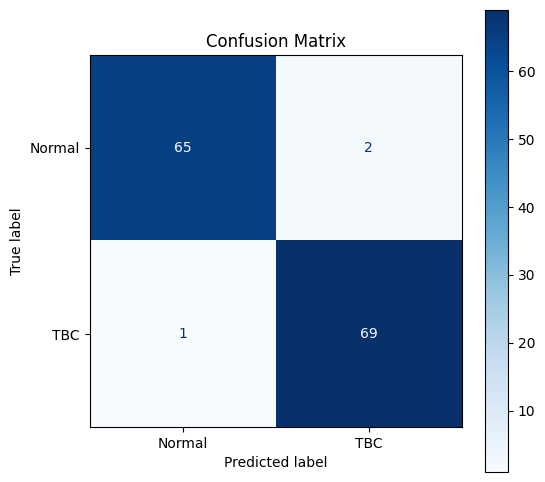

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define confussion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'TBC'])

# Plotting
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.show()


## Save Model

In [37]:
# Save model into (.h5) extension
model.save('model_tbc.h5')


## Load and Test Model

Saving Normal-1.png to Normal-1 (2).png


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Gambar: Normal-1 (2).png
Prediksi: Normal
Probabilitas TBC: 0.43%
Probabilitas Normal: 99.57%


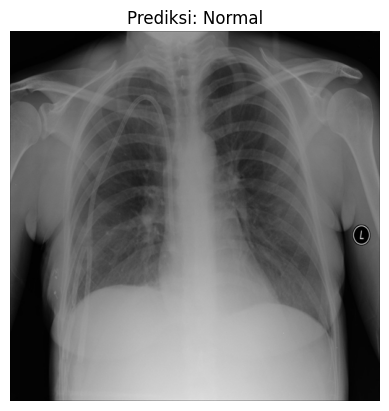

In [47]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Upload image
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Load model
model = load_model('model_tbc.h5')  # Tanpa compile=False jika tidak pakai custom loss

# Classes
classes = ['Normal', 'TBC']

# Load & preprocess image
img = image.load_img(img_path, target_size=(320, 320))  # Sesuai training
img_array = image.img_to_array(img)

# Preprocessing: sesuai train_generator!
img_array -= np.mean(img_array)
img_array /= (np.std(img_array) + 1e-7)  # samplewise_center + samplewise_std_normalization

img_array = np.expand_dims(img_array, axis=0)

# Predict
pred = model.predict(img_array)
prob = pred[0][0]
predicted_class = classes[1] if prob >= 0.5 else classes[0]

# Output
print("Gambar:", img_path)
print("Prediksi:", predicted_class)
print("Probabilitas TBC:", f"{prob * 100:.2f}%")
print("Probabilitas Normal:", f"{(1 - prob) * 100:.2f}%")

# Show image
plt.imshow(image.load_img(img_path))
plt.title(f"Prediksi: {predicted_class}")
plt.axis('off')
plt.show()
